# AIM: test the radius of influence ('ri') parameter in nearest neighbour resampling

This notebook demonstrates the difference in resampled MODIS L2 swath data when the radius of influence ('ri') parameter in the `pyresample` `resample_nearest` function is altered. 

The method is based upon an example from hdfeos.org (http://hdfeos.org/zoo/MORE/LAADS/MOD/MOD04_L2_regrid.py)

### Import packages required


In [1]:
import os #general utility
import glob #general utility                                                                 
import numpy as np #general utility
import copy #general utility
from pyhdf.SD import SD, SDC #for reading the L2 hdf files
from pyresample import kd_tree,geometry #regridding
from pyresample.geometry import GridDefinition, SwathDefinition #regridding
from pyresample.kd_tree import resample_nearest #regridding
import matplotlib.pyplot as plt #plotting tools
import cartopy.crs as ccrs #plotting tools
import cartopy.feature as cf #plotting tools
import xarray as xr #for saving results to netcdf for later analysis

### Create a function for reading a SDS (and corresponding latlons) from file
- It is easiest to place this in a function as SDS requires screening for fillvalues and correcting according to in-file attributes before it is ready for analysis
    - (Therefore do not want to repeatedly do this in main processing loop)
- (_SDS = 'Scientific Data Set'_)

In [2]:
def read_hdf(file, DATAFIELD_NAME):
    
    '''
    -read a specified datafield ('SDS') from a MODIS L2 hdf file
    -screen missing values and correct real values according to in-file offset and scale-factor attributes
    -read corresponding latlons
    -return the analysis-ready datafield (as a masked array) and latlons to parent process
    
    '''
    
    #open file and get data field
    reader=open(file)
    hdf=SD(file,SDC.READ)
    data2d=hdf.select(DATAFIELD_NAME)
    data=data2d[:,:].astype(np.double)

    
    #get latlons and variable attributes
    lat=hdf.select('Latitude_10km')
    latitude=lat[:,:]
    lon=hdf.select('Longitude_10km')
    longitude=lon[:,:]

    attrs=data2d.attributes(full=1)
    add_offset=attrs['add_offset'][0]
    _FillValue=attrs['_FillValue'][0]
    scale_factor=attrs['scale_factor'][0]
    units=attrs['units'][0]

    
    #prepare datafield for processing
    data[data==_FillValue]=np.nan
    data=(data-add_offset)*scale_factor 
    datam=np.ma.masked_array(data,np.isnan(data))

    
    #return datafield prepared for analysis, and latlons
    return datam,latitude,longitude


    #done

### Define the target grid to regrid swath data to once it has been read
- Target projection = standard latlon grid, 0.1 x 0.1 degree resolution

**NOTE:** \
This is almost a direct copy of the example from hdfeos.org, but I am testing different values for the radius of influence (`ri`) parameter, which was set to 10000 (meters) in that example. 

In [3]:
#specify target grid features
#(NOTE: global grid is unnecessary but is simple for now!)
min_lon = -180
max_lon = 180
min_lat = -90
max_lat = 90
cellSize = 0.1 #0.1 x 0.1 degree resolution

x0, xinc, y0, yinc = (min_lon, cellSize, max_lat, -cellSize)


#derive number of grid boxes in x and y direction
nx = int(np.floor((max_lon - min_lon) / cellSize))
ny = int(np.floor((max_lat - min_lat) / cellSize))


#derive x and y coordinates
x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
lon_g,lat_g = np.meshgrid(x, y)


#create target grid object using pyresample 
grid_def = GridDefinition(lons = lon_g, lats = lat_g)


#Set radius_of_influence in meters for the reprojection.
#ri = 50000 #increased from 10000 in hdfeos.org regrid example 

### Specify location of files to process (datadir) and name of datafield to read from files

- (some utility code is included here (commented out) for inspecting contents of file)

In [4]:
datadir = '/path/to/files/' #'/Users/ianashpole/Computing/DUST/data/modis/L2/501885579/'
DATAFIELD_NAME='Viewing_Zenith_10km'

# block below for inspecting SDSs contained in files
# FILE_NAME=datadir+'MYDATML2.A2022214.1830.061.2022215180306.hdf'
# hdf = SD(FILE_NAME, SDC.READ)
# print(hdf.datasets())

# block below for inspecting attributes attached to this datafield ('SDS')
# data2d=hdf.select(DATAFIELD_NAME)
# data=data2d[:,:].astype(np.double)
# attrs=data2d.attributes(full=1)
# print(attrs)

### Read swath data and resample

- Use `read_hdf` function and target grid defintion set above
- Resample the swath multiple times using the same method but with variable `ri` values 

In [5]:
#1. get file to read
file=datadir+'MYDATML2.A2022214.1200.061.2022215174300.hdf'
    
    
#2. read analysis-ready SDS ('datam') and latlons from file using read_hdf function created above.
#this is the 'swath'
datam, latitude, longitude = read_hdf(file, DATAFIELD_NAME)
    
    
#3. regrid the swath ('swath_r') using grid initialised above
swathDef = SwathDefinition(lons = longitude, lats = latitude)   

swath_r_ri10000 = resample_nearest(swathDef, datam, grid_def, radius_of_influence = 10000, 
                           epsilon = 0.5, fill_value = np.nan)
swath_r_ri25000 = resample_nearest(swathDef, datam, grid_def, radius_of_influence = 25000, 
                           epsilon = 0.5, fill_value = np.nan)
swath_r_ri50000 = resample_nearest(swathDef, datam, grid_def, radius_of_influence = 50000, 
                           epsilon = 0.5, fill_value = np.nan)
swath_r_ri100000 = resample_nearest(swathDef, datam, grid_def, radius_of_influence = 100000, 
                           epsilon = 0.5, fill_value = np.nan)

### Plot the results
- Compare the swaths resampled with different values for the `ri` parameter

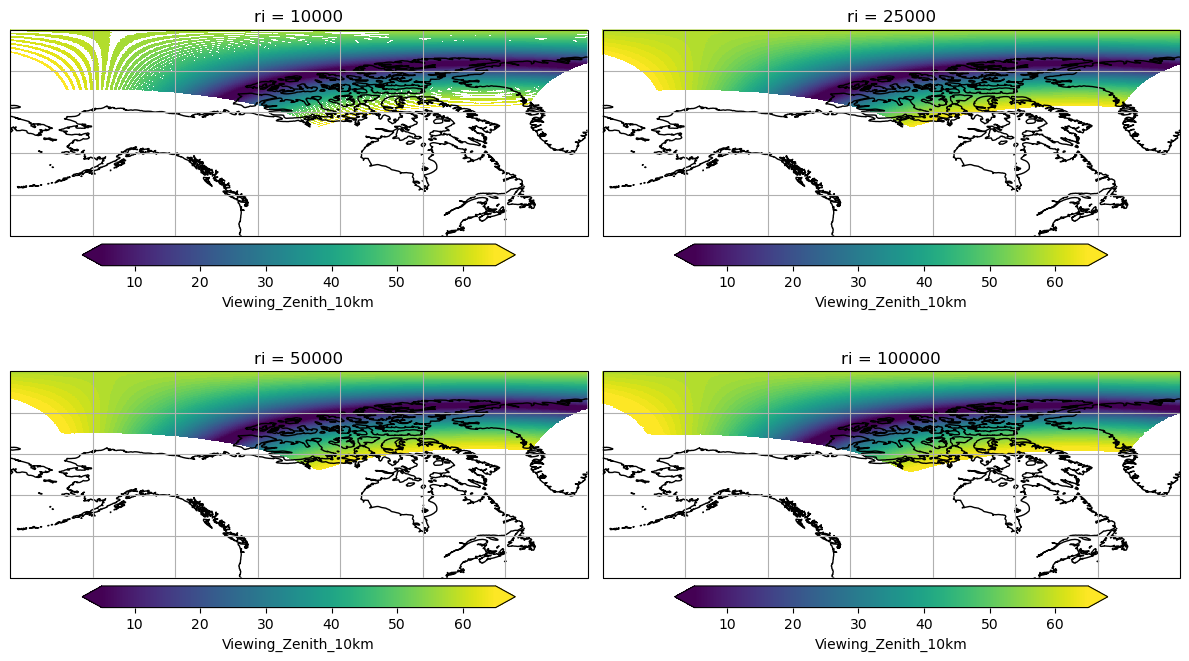

In [6]:
#initialise plot
fig, axes = plt.subplots(nrows = 2, ncols = 2,
                       subplot_kw = {'projection': ccrs.PlateCarree()},
                       figsize = (12,12))


#specify fields to plot (and useful titles)
flds = [swath_r_ri10000, swath_r_ri25000, swath_r_ri50000, swath_r_ri100000]
titles = ['ri = 10000', 'ri = 25000', 'ri = 50000', 'ri = 100000']


#loop
for plotpos in range(0,4):


    #get ax to plot on to
    ax = axes.flatten()[plotpos]

    
    #set up map, plot data, add map features
    ax.set_extent([-180,-40,40,90], ccrs.PlateCarree())
    img = ax.pcolormesh(lon_g, lat_g, flds[plotpos], transform = ccrs.PlateCarree(),
                    cmap = plt.cm.viridis, vmin = 5, vmax = 65)

    ax.coastlines()
    ax.gridlines()
    ax.set_title(titles[plotpos])

    
    #add cbar
    cbar = fig.colorbar(img, ax = ax, orientation = 'horizontal', extend = 'both', 
                        shrink = 0.75, pad = 0.01) #fraction = 0.02
    cbar.set_label(DATAFIELD_NAME)


#finalise plot
fig.subplots_adjust(hspace=-0.75)
fig.tight_layout()
plt.show()

### Analysis

The features in the northern- and western-most portions of the swath resampled with an `ri` of __10000__ (top left) occur because _the spatial resolution of the raw swath increases towards the swath edge_ as the viewing angle increases (i.e. individual pixels become more stretched). This results in the lat,lon values of pixels in the raw swath not falling within 10000m (~0.1degree) of the lat,lon of the target grid. 

Expanding the `ri` allows for these 'edge' grid boxes in the target grid to be filled with values from pixels that are further away, removing the regridding artefacts. This does not (-should not?) negatively affect grid boxes closer to the instrument nadir, since _the nearest neigbour method by definition fills the grid box with the value from the nearest pixel in the input swath_. 

Although the artefacts seem to be removed for an `ri` of __25000__, I have chosen to go with the value of __50000__ in my work for extra safety and because, as far as I can tell, there is no negative impact of increasing to this value (or even to 100000), at least for these small swath segments. This value seems reasonable given that pixels towards the swath edge can stretch to 0.4 to 0.5 degrees (I think! This step could probably be refined with more complex reprojection methods from an expert...)



# FINISHED